In [1]:
from qiskit import QuantumCircuit, IBMQ, execute, QuantumRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
import numpy as np
from math import sqrt, pi
hadamard=np.array([[complex(1/sqrt(2),0),complex(1/sqrt(2),0)],
                   [complex(1/sqrt(2),0),complex(-1/sqrt(2),0)]])
pauli_X=np.array([[complex(0,0),complex(1,0)],
                   [complex(1,0),complex(0,0)]])

In [2]:
def preCalculation(lamb,b):
    A=np.array([[1/2,lamb-1/2],[lamb-1/2,1/2]])
    A_inv=np.linalg.inv(A)
    x_unnorm=A_inv.dot(b)
    norm=np.linalg.norm(x_unnorm,2)
    c_lamb=1/norm
    return c_lamb

In [3]:
def createStatePreparationCircuit(qb,c):
    statePreparationCircuit=QuantumCircuit(qb)
    if c=="0":
        statePreparationCircuit.id(0) 
    elif c=="+":
        statePreparationCircuit.h(0) 
    elif c=="b2":
        statePreparationCircuit.ry(pi/4,0)
        statePreparationCircuit.rz(-pi/4,0)
    return statePreparationCircuit

In [4]:
def createPhaseEstimationCircuit(qb,qev,lamb):
    phaseEstimationCircuit=QuantumCircuit(qev,qb)
    #superposition of eigenvalue register
    phaseEstimationCircuit.h(qev[0])
    phaseEstimationCircuit.h(qev[1])
    #apply Controlled Hamiltonian U _lamb  with qev[1] as control
    m=1
    phaseEstimationCircuit.h(qb[0])
    phaseEstimationCircuit.rz(2*pi*lamb*m,qb[0])
    phaseEstimationCircuit.cx(qev[1],qb[0])
    phaseEstimationCircuit.rz(2*pi*lamb*m,qb[0])
    phaseEstimationCircuit.cx(qev[1],qb[0])
    phaseEstimationCircuit.rz(-4*pi*lamb*m,qb[0])
    phaseEstimationCircuit.h(qb[0]) 

    #apply Controlled Hamiltonian U _lamb ^2 with qev[0] as control
    m=2
    phaseEstimationCircuit.h(qb[0]) #inverse to step before
    phaseEstimationCircuit.rz(2*pi*lamb*m,qb[0])
    phaseEstimationCircuit.cx(qev[0],qb[0])
    phaseEstimationCircuit.rz(2*pi*lamb*m,qb[0])
    phaseEstimationCircuit.cx(qev[0],qb[0])
    phaseEstimationCircuit.rz(-4*pi*lamb*m,qb[0])
    phaseEstimationCircuit.h(qb[0])

    #apply inverse Fourier transform

    phaseEstimationCircuit.cx(qev[0],qev[1])
    phaseEstimationCircuit.cx(qev[1],qev[0]) #this was a swap
    phaseEstimationCircuit.cx(qev[0],qev[1])
    phaseEstimationCircuit.rz(-pi/2,qev[0])
    phaseEstimationCircuit.h(qev[1])
    phaseEstimationCircuit.tdg(qev[1])
    phaseEstimationCircuit.cx(qev[1],qev[0])
    phaseEstimationCircuit.rz(pi/4,qev[0])
    phaseEstimationCircuit.cx(qev[1],qev[0])
    phaseEstimationCircuit.rz(pi/4,qev[0])
    phaseEstimationCircuit.h(qev[0])
    
    return phaseEstimationCircuit

In [5]:
def createEigenvalueInversionCircuit(qa,qev,c_lamb):
    theta_1=2*np.arccos(sqrt(1-(c_lamb/1)**2))
    theta_2=2*np.arccos(sqrt(1-(c_lamb/2)**2))
    theta_3=2*np.arccos(sqrt(1-(c_lamb/3)**2))
    aqeCircuit=QuantumCircuit(qa,qev)
    aqeCircuit.ry(theta_1,qa[0])
    aqeCircuit.cry(theta_3-theta_1,qev[0],qa[0])
    return aqeCircuit

In [6]:
def testOnRealDevice(qc,backend):
    job = execute(qc, backend=backend, shots=4096,optimization_level=3)
    job_monitor(job, interval = 2)
    result= job.result()
    counts = result.get_counts()
    if "0001" not in counts:
        c_plus_square=0
    else:
        c_plus_square=counts["0001"]
    if "1001" not in counts:
        c_minus_square=0
    else:
        c_minus_square=counts["1001"]
    m=c_plus_square+c_minus_square
    average=(c_plus_square-c_minus_square)/m
    print("<x|X|x>=",average)
    return counts

In [7]:
# Get input states |b>:
inputs={'0':np.array([1, 0]),'+':hadamard.dot(np.array([1, 0])),'b2':np.array([0.92388,complex(0.270598,-0.270598)])}
# Setting up parameters
lamb=1/2
c='0'
b=inputs[c]
c_lamb=preCalculation(lamb,b)
backendName="ibmq_rome"
IBMQ.load_account()
provider=IBMQ.get_provider(hub='ibm-q')
backend=provider.get_backend(backendName)

In [8]:
qa=QuantumRegister(1,name="a") #store ancilla
qev=QuantumRegister(2,name="r") #store both eigenvalues
qb=QuantumRegister(1,name="m") #store |b>
qc=QuantumCircuit(qa,qev,qb)
qc=qc+createStatePreparationCircuit(qb,c)
qc.barrier()
phaseEstimationCircuit=createPhaseEstimationCircuit(qb,qev,lamb)
qc=qc+phaseEstimationCircuit
qc.barrier();
aqeCircuit=createEigenvalueInversionCircuit(qa,qev,c_lamb)
qc=qc+aqeCircuit
qc.barrier();
qc=qc+phaseEstimationCircuit.inverse()
qc.barrier();
#measure |x> in X basis
qc.h(qb[0])
qc.measure_all()

Job Status: job has successfully run
<x|X|x>= 0.08235294117647059


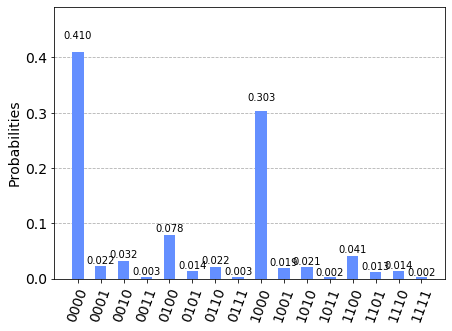

In [9]:
counts = testOnRealDevice(qc,backend)
plot_histogram(counts) 

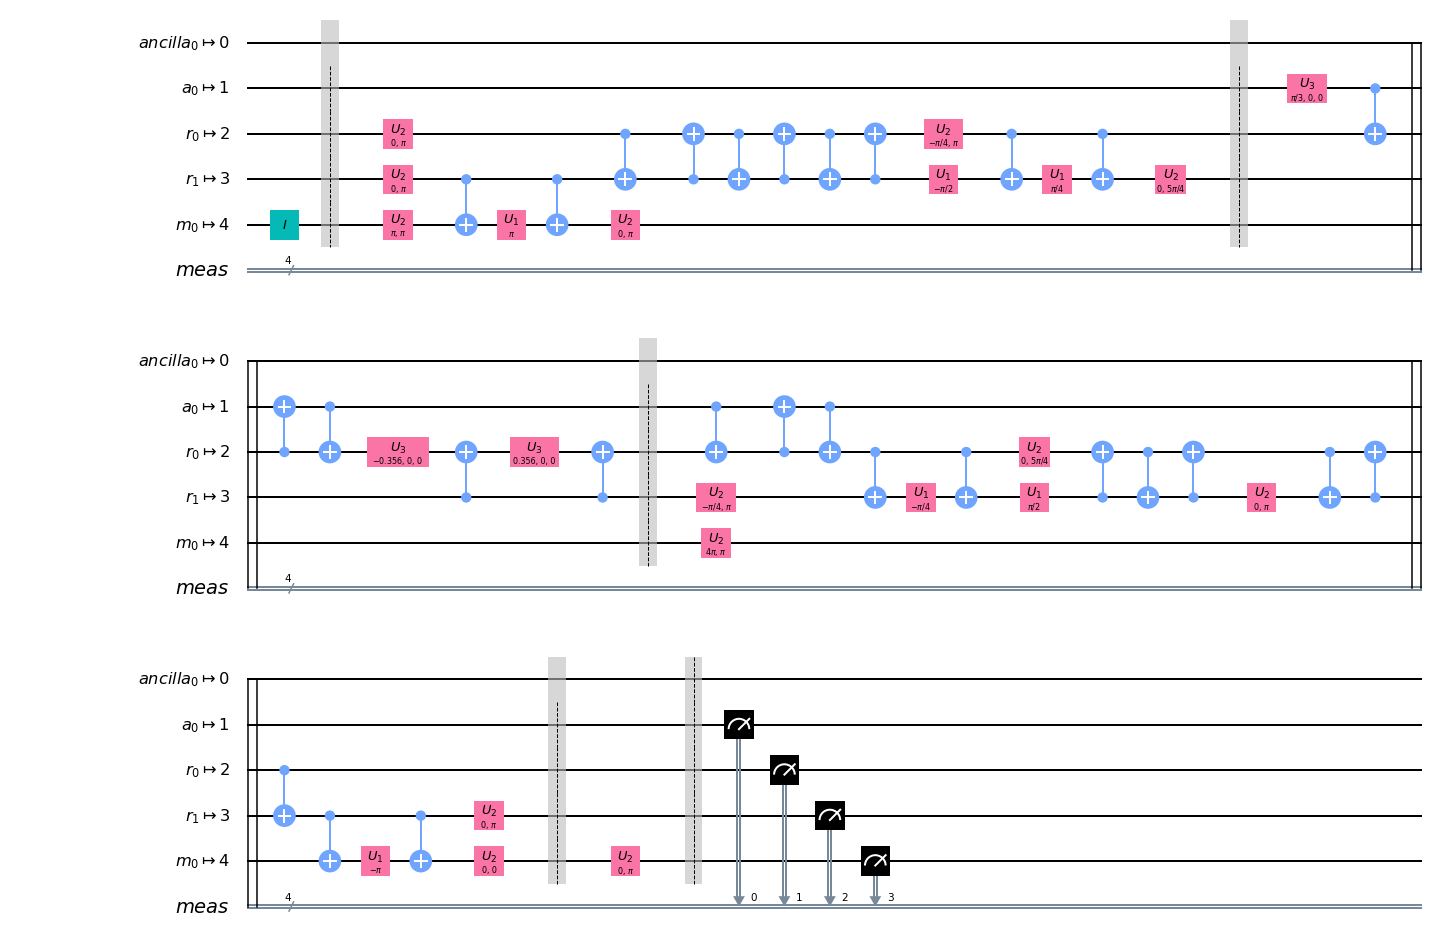

In [10]:
# this is the circuit that was actually used:
qc_trans=transpile(qc,backend)
qc_trans.draw('mpl')